In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

zsh:1: command not found: nvidia-smi


In [2]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
    print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.8.10 | packaged by conda-forge | (default, May 11 2021, 06:27:18) 
[Clang 11.1.0 ]

NumPy 1.19.5
Init Plugin
Init Graph Optimizer
Init Kernel
TensorFlow 2.5.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


## 1. Load the pre-trained VGG-16 (only the feature extractor)

In [3]:
# Load the ImageNet VGG-16 model, ***excluding*** the latter part regarding the classifier
# Default of input_shape is 224x224x3 for VGG-16
img_w,img_h = 32,32
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))

vgg_extractor.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-08-17 19:49:29.985410: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-17 19:49:29.985822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

## 2. Extend VGG-16 to match our requirement

In [4]:
# Freeze all layers in VGG-16
for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable} => {False}" )
    layer.trainable = False    # freeze this layer

Layer 0: name = input_1 , trainable = True => False
Layer 1: name = block1_conv1 , trainable = True => False
Layer 2: name = block1_conv2 , trainable = True => False
Layer 3: name = block1_pool , trainable = True => False
Layer 4: name = block2_conv1 , trainable = True => False
Layer 5: name = block2_conv2 , trainable = True => False
Layer 6: name = block2_pool , trainable = True => False
Layer 7: name = block3_conv1 , trainable = True => False
Layer 8: name = block3_conv2 , trainable = True => False
Layer 9: name = block3_conv3 , trainable = True => False
Layer 10: name = block3_pool , trainable = True => False
Layer 11: name = block4_conv1 , trainable = True => False
Layer 12: name = block4_conv2 , trainable = True => False
Layer 13: name = block4_conv3 , trainable = True => False
Layer 14: name = block4_pool , trainable = True => False
Layer 15: name = block5_conv1 , trainable = True => False
Layer 16: name = block5_conv2 , trainable = True => False
Layer 17: name = block5_conv3 , t

In [5]:
x = vgg_extractor.output

# Add our custom layer(s) to the end of the existing model 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

# Create the final model 
model = tf.keras.models.Model(inputs=vgg_extractor.input, outputs=new_outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

## 3. Prepare our own dataset

In [6]:
# Load CIFAR-10 color image dataset
(x_train , y_train), (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

# Inspect the dataset
print( f"x_train: type={type(x_train)} dtype={x_train.dtype} shape={x_train.shape} max={x_train.max(axis=None)} min={x_train.min(axis=None)}" )
print( f"y_train: type={type(y_train)} dtype={y_train.dtype} shape={y_train.shape} max={max(y_train)} min={min(y_train)}" )
print( f"x_test: type={type(x_test)} dtype={x_test.dtype} shape={x_test.shape} max={x_test.max(axis=None)} min={x_test.min(axis=None)}" )
print( f"y_test: type={type(y_test)} dtype={y_test.dtype} shape={y_test.shape} max={max(y_test)} min={min(y_test)}" )

x_train: type=<class 'numpy.ndarray'> dtype=uint8 shape=(50000, 32, 32, 3) max=255 min=0
y_train: type=<class 'numpy.ndarray'> dtype=uint8 shape=(50000, 1) max=[9] min=[0]
x_test: type=<class 'numpy.ndarray'> dtype=uint8 shape=(10000, 32, 32, 3) max=255 min=0
y_test: type=<class 'numpy.ndarray'> dtype=uint8 shape=(10000, 1) max=[9] min=[0]


In [9]:
y_train[0:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

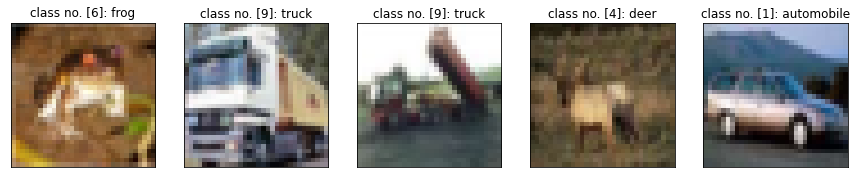

In [10]:
cifar10_labels = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]

# Visualize the first five images in x_train
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(150 + 1 + i).set_title( f"class no. {y_train[i]}: {cifar10_labels[ int(y_train[i]) ]}" )                
    plt.imshow( x_train[i] )
    plt.setp( plt.gcf().get_axes(), xticks=[], yticks=[])        # remove all tick marks 
plt.show()

In [ ]:
# Preprocess CIFAR-10 dataset to match VGG-16's requirements
x_train_vgg = tf.keras.applications.vgg16.preprocess_input(x_train)
x_test_vgg = tf.keras.applications.vgg16.preprocess_input(x_test)

print( x_train_vgg.dtype, x_train_vgg.shape, np.min(x_train_vgg), np.max(x_train_vgg) )
print( x_test_vgg.dtype, x_test_vgg.shape, np.min(x_test_vgg), np.max(x_test_vgg) )

## 4. Transfer learning

In [ ]:
# Set loss function, optimizer and evaluation metric
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] ) 

In [ ]:
history = model.fit( x_train_vgg, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(x_test_vgg,y_test) )

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

## 5. Evaluate and test the model

In [ ]:
# Evaluate the trained model on the test set
results = model.evaluate(x_test_vgg, y_test, batch_size=128)
print("test loss, test acc:", results)

In [ ]:
# Test using the model on x_test_vgg[0]
i = 0
y_pred = model.predict( x_test_vgg[i].reshape(1,32,32,3) )

plt.imshow( x_test[i] )
plt.title( f"x_test[{i}]: predict=[{np.argmax(y_pred)}]{cifar10_labels[np.argmax(y_pred)]}, true={y_test[i]}{cifar10_labels[int(y_test[i])]}" )
plt.show()

In [ ]:
# Test using the model on the first 20 images in x_test
for i in range(20):
  y_pred = model.predict( x_test_vgg[i].reshape(1,32,32,3) )

  plt.imshow( x_test[i] )
  plt.title( f"x_test[{i}]: predict=[{np.argmax(y_pred)}]{cifar10_labels[np.argmax(y_pred)]}, true={y_test[i]}{cifar10_labels[int(y_test[i])]}" )
  plt.show()